# Machine Learning
In this module we will see a bit about machine learning and how it can be applied to geosciences.

Machine learning is a branch of artificial intelligence (AI) focused on building applications that learn from data and improve their accuracy over time without being programmed to do so. In machine learning, algorithms use statistical techniques to give computers the ability to "learn" with incoming data and make decisions based on that data. Machine learning is used in a range of computing tasks where designing and programming explicit, rule-based algorithms is infeasible, such as in email filtering, detection of network intruders, and computer vision. The core of machine learning deals with representation and generalization—representing data in a form that machines can learn from so that they can make generalizations or predictions about future data.

Machine learning can be used for countless different applications in geosciences and elsewhere. Problems that can be tackled by Machine Learning include classification, clustering and regression.
- Classification: We know what labels exist and we want to know where our data fits
- Clustering: We are not too sure about labels, but we want to see how our data is grouped
- Regression: Given the data that we have, what responses should we expect if the inputs were different?


In this module, we will explore the application of machine learning algorithms, specifically the Random Forest algorithm, to categorize the tectonic setting of igneous rocks based on their geochemical composition. The Random Forest is an ensemble learning method known for its accuracy and ability to handle large datasets with multiple variables. We'll use it to analyze and learn from the geochemical signatures of rocks to predict their geological formation environment. This approach will allow us to understand how different elements and compounds present in the rocks correlate with various tectonic settings.


References for this module:

[Scikit-learn](https://scikit-learn.org/stable/index.html)

Soares, M. B., et al. (2018). "Multistage mineralization at the hypozonal São Sebastião gold deposit, Pitangui greenstone belt, Minas Gerais, Brazil." Ore Geology Reviews 102: 618-638. https://doi.org/10.1016/j.oregeorev.2018.09.028


In [173]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [ ]:
# Import the pandas library for data manipulation
import pandas as pd

# --- Load the dataset ---

# Define the file path to the CSV data file for the Biquinho deposit
url = r"https://raw.githubusercontent.com/pierosampaio/PythonWorkshop/refs/heads/main/GSA-WA%202025%20Data/MBS2018_Biquinho.csv"

# Read the CSV file into a pandas DataFrame
# 'delimiter=','' ensures the file is parsed using commas
df_Biquinho = pd.read_csv(url, delimiter=',')

# Reset the index of the DataFrame to default integer index
# This is useful in case the original file had custom indexing
df_Biquinho = df_Biquinho.reset_index()

# Drop any columns that contain only NaN (missing) values
# 'axis=1' means we're operating on columns
# 'how="all"' means a column is dropped only if *all* its values are NaN
df_Biquinho = df_Biquinho.dropna(axis=1, how='all')

# --- Clean the dataset ---

# Remove any rows that contain at least one NaN value
# This helps ensure we are working with complete data for analysis or modeling
df_Biquinho = df_Biquinho.dropna()


In [175]:
#We explore the dataframe
df_Biquinho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 0 to 276
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   275 non-null    int64  
 1   Body    275 non-null    object 
 2   Sample  275 non-null    object 
 3   Au_ppb  275 non-null    float64
 4   Ag_ppm  275 non-null    float64
 5   As_ppm  275 non-null    float64
 6   Bi_ppm  275 non-null    float64
 7   Cr_ppm  275 non-null    float64
 8   Cu_ppm  275 non-null    float64
 9   Pb_ppm  275 non-null    float64
 10  Zn_ppm  275 non-null    float64
 11  Al_pct  275 non-null    float64
 12  Fe_pct  275 non-null    float64
 13  S_ppm   275 non-null    float64
 14  Sb_ppm  275 non-null    float64
 15  Te_ppm  275 non-null    float64
 16  Ti_pct  275 non-null    float64
 17  Co_ppm  275 non-null    float64
 18  Ni_ppm  275 non-null    float64
 19  Ba_ppm  275 non-null    float64
 20  Cd_ppm  275 non-null    float64
 21  Mg_pct  275 non-null    float64
 22  Mn_pct 

In [ ]:
#Open data for Pimentao deposit
url = r"https://raw.githubusercontent.com/pierosampaio/PythonWorkshop/refs/heads/main/GSA-WA%202025%20Data/MBS2018_Pimentao.csv"
df_Pimentao = pd.read_csv(url, delimiter=',')
df_Pimentao = df_Pimentao.reset_index()
df_Pimentao = df_Pimentao.dropna(axis=1, how='all')

#Remove rows from df_Biquinho that contain any NaN (missing) values
df_Pimentao = df_Pimentao.dropna()

In [177]:
df_Pimentao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   233 non-null    int64  
 1   Body    233 non-null    object 
 2   Sample  233 non-null    object 
 3   Co_ppm  233 non-null    float64
 4   Ni_ppm  233 non-null    float64
 5   Al_pct  233 non-null    float64
 6   Ti_pct  233 non-null    float64
 7   S_ppm   233 non-null    float64
 8   Au_ppb  233 non-null    int64  
 9   Ag_ppm  233 non-null    float64
 10  As_ppm  233 non-null    float64
 11  Bi_ppm  233 non-null    float64
 12  Cu_ppm  233 non-null    float64
 13  Pb_ppm  233 non-null    float64
 14  Zn_ppm  233 non-null    float64
 15  Sn_ppm  233 non-null    float64
 16  Sr_ppm  233 non-null    int64  
 17  Th_ppm  233 non-null    float64
 18  Be_ppm  233 non-null    float64
 19  Tl_ppm  233 non-null    float64
 20  U_ppm   233 non-null    float64
 21  W_ppm   233 non-null    float64
 22  Y_

In [178]:
# --- Step 1: Identify common columns between two DataFrames ---

# Use the .intersection() method to find column names that are shared between df_Biquinho and df_Pimentao
# This ensures we only combine columns that exist in both DataFrames
common_columns = df_Biquinho.columns.intersection(df_Pimentao.columns)

# --- Step 2: Concatenate the two DataFrames using only the common columns ---

# Select the shared columns from both DataFrames using the list of common columns
# Then concatenate (stack) the two DataFrames vertically (row-wise)
# This merges the data while preserving only the columns they have in common
df_combined = pd.concat(
    [df_Biquinho[common_columns], df_Pimentao[common_columns]],
    ignore_index=True  # Resets the row index in the combined DataFrame to be sequential
)


In [179]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

# Data sparsity
Data sparsity is a prevalent issue that requires careful evaluation, as it can significantly impact machine learning outcomes. Sparse datasets, being thinly populated with non-zero values, are often challenging for algorithms to interpret and can be considered a critical parameter in model performance and accuracy. It's essential to assess the degree of sparsity in our data to develop effective strategies for dealing with it.

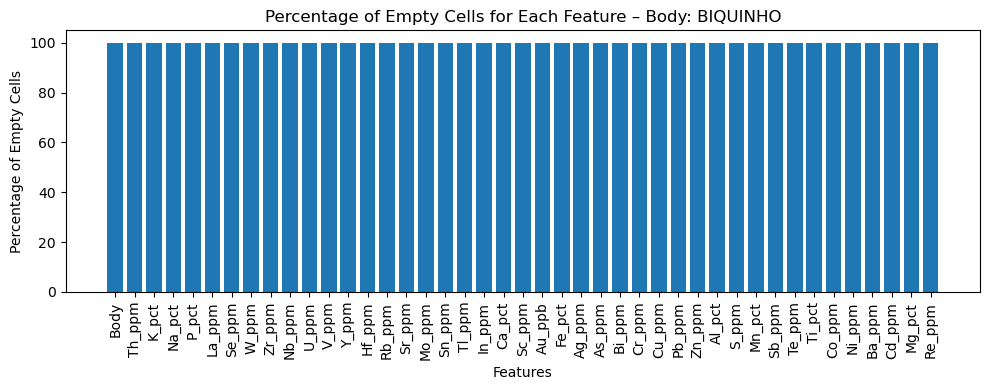

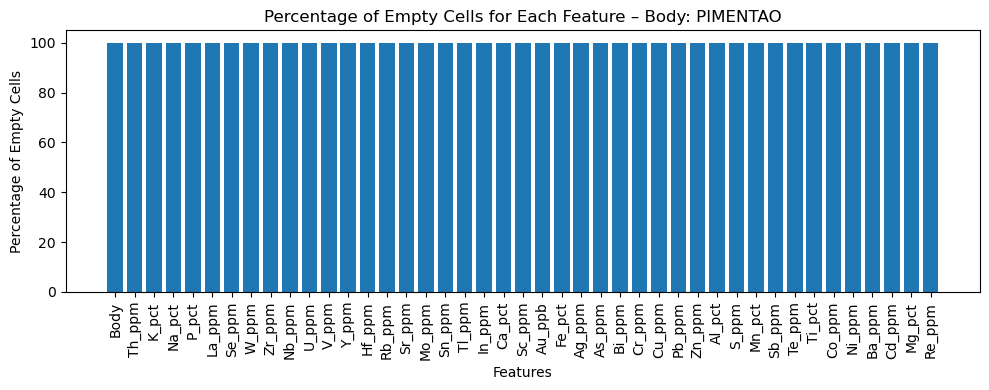

In [180]:
# Import necessary libraries
import matplotlib.pyplot as plt  # For plotting
import re  # For formatting feature names with subscripts

# Create a copy of the combined DataFrame for plotting
df_combined_plot = df_combined

# --- Loop through each unique 'Body' in the dataset ---

# Iterate over all unique values in the 'Body' column
for body in df_combined_plot['Body'].unique():

    # Filter the DataFrame to include only rows where 'Body' matches the current value
    df_body = df_combined_plot[df_combined_plot['Body'] == body]

    # Drop the 'index' and 'Sample' columns as they are not needed for this analysis
    df_body = df_body.drop(['index', 'Sample'], axis=1)

    # --- Calculate percentage of non-empty (non-NaN) cells per column ---

    # .notnull() gives True for non-NaN values; .sum() counts them per column
    # Divide by total number of rows and multiply by 100 to get percentages
    non_empty_percentages = (df_body.notnull().sum() / len(df_body)) * 100

    # --- Sort and filter features based on missing data ---

    # Sort the features by percentage in descending order (most complete first)
    sorted_features = non_empty_percentages.sort_values(ascending=False)

    # Keep only features where some data is missing (i.e., less than 100% complete)
    sorted_features = sorted_features[sorted_features > 0]

    # --- Format feature names for better readability in plots ---

    # Use regular expressions to convert numbers in feature names to subscripts
    # For example, 'Pb1' becomes 'Pb$_{1}$'
    formatted_features = [
        re.sub(r'(\d+)', r'$_{\1}$', feature)
        for feature in sorted_features.index
    ]

    # --- Plot the bar chart ---

    plt.figure(figsize=(10, 4))  # Set figure size
    plt.bar(formatted_features, sorted_features.values)  # Create bar plot
    plt.xlabel('Features')  # Label for x-axis
    plt.ylabel('Percentage of Empty Cells')  # Label for y-axis
    plt.title(f'Percentage of Empty Cells for Each Feature – Body: {body}')  # Chart title
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


In [181]:
# Import necessary libraries
import numpy as np  # For numerical operations and random number generation
import pandas as pd  # For data manipulation

# --- Create an artificial sparse dataset based on df_combined ---

# Make a copy of the combined DataFrame to avoid altering the original
df_sparse = df_combined.copy()

# --- Define which columns to exclude from adding missing values ---

# These columns are considered metadata or identifiers, so we keep them intact
exclude_cols = ['index', 'Body', 'Sample']

# Create a list of columns that will be sparsified (all except the excluded ones)
target_cols = [col for col in df_sparse.columns if col not in exclude_cols]

# --- Define the range of sparsity to apply ---

# Set the starting sparsity level for the first column (10% values will be missing)
start_sparsity = 0.1  # Least sparse

# Set the ending sparsity level for the last column (90% values will be missing)
end_sparsity = 0.9  # Most sparse

# Generate a series of sparsity levels, increasing linearly across the target columns
# This ensures a gradient from low to high missingness
sparsity_levels = np.linspace(start_sparsity, end_sparsity, num=len(target_cols))

# --- Apply the generated sparsity to each target column ---

# Loop over each column and its corresponding sparsity level
for col, sparsity in zip(target_cols, sparsity_levels):
    
    # Generate a random mask where 'True' indicates a value to be set to NaN
    # The proportion of 'True' values matches the desired sparsity level
    mask = np.random.rand(len(df_sparse)) < sparsity
    
    # Apply the mask to the column, setting selected values to NaN
    df_sparse.loc[mask, col] = np.nan


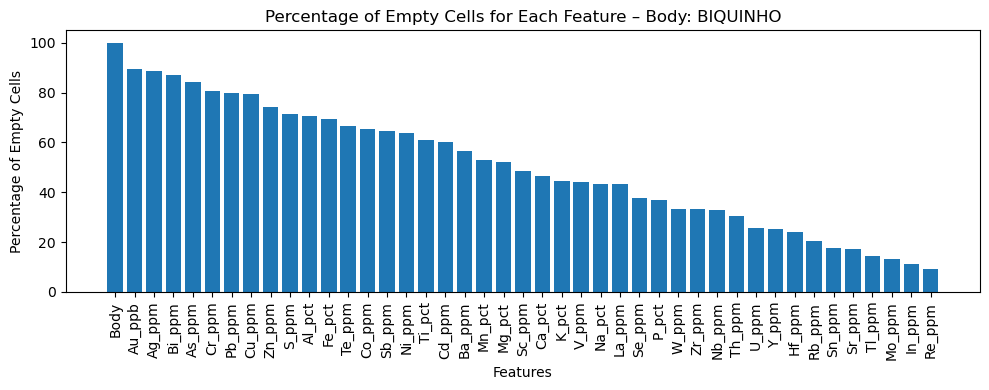

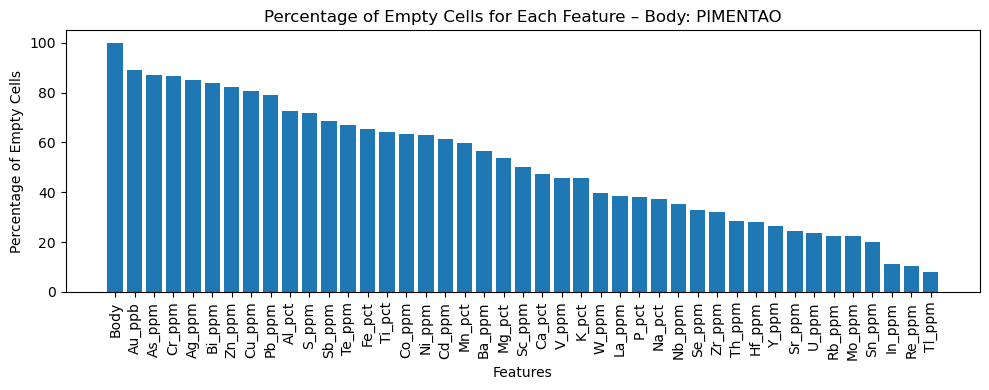

In [182]:
# --- Loop through each unique geological Body in the sparse dataset ---

# Iterate over all unique values in the 'Body' column of the sparse DataFrame
for body in df_sparse['Body'].unique():

    # --- Filter the DataFrame to include only rows belonging to the current Body ---

    # This allows missing data analysis to be performed separately for each geological unit
    df_body = df_sparse[df_sparse['Body'] == body]

    # Drop the 'index' and 'Sample' columns, as they are not relevant to feature analysis
    df_body = df_body.drop(['index', 'Sample'], axis=1)

    # --- Calculate the percentage of non-empty (non-NaN) values for each feature ---

    # .notnull() returns True for non-NaN values; .sum() counts them per column
    # Divide by the number of rows and multiply by 100 to get the percentage of filled (non-missing) cells
    non_empty_percentages = (df_body.notnull().sum() / len(df_body)) * 100

    # --- Sort and filter features based on completeness ---

    # Sort the features by percentage of completeness in descending order
    sorted_features = non_empty_percentages.sort_values(ascending=False)

    # Retain only features that have some missing data (less than 100% complete)
    sorted_features = sorted_features[sorted_features > 0]

    # --- Format feature names for display ---

    # Use regular expressions to convert digits in feature names to subscripts (e.g., 'Pb1' → 'Pb$_{1}$')
    formatted_features = [
        re.sub(r'(\d+)', r'$_{\1}$', feature)
        for feature in sorted_features.index
    ]

    # --- Plot the bar chart showing missing data percentages ---

    plt.figure(figsize=(10, 4))  # Set the plot size
    plt.bar(formatted_features, sorted_features.values)  # Plot a bar chart of non-empty percentages
    plt.xlabel('Features')  # X-axis label
    plt.ylabel('Percentage of Empty Cells')  # Y-axis label (note: it's inverse of completeness)
    plt.title(f'Percentage of Empty Cells for Each Feature – Body: {body}')  # Chart title indicating the current Body
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to avoid overlapping elements
    plt.show()  # Display the plot


In [183]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

# Sparsity pattern plots

Sparsity pattern plots are essential in data analysis for identifying the distribution and prevalence of non-zero values in a dataset. They provide immediate visual feedback on data density and potential patterns, which is critical for understanding the dataset's structure. These plots also highlight areas with missing information, guiding the data cleaning and preprocessing steps. By revealing the extent of sparsity, they help in determining the suitability of various machine learning algorithms, as some algorithms may perform poorly with sparse data. Thus, sparsity pattern plots are a valuable tool for improving data quality and preparing datasets for effective machine learning model building.

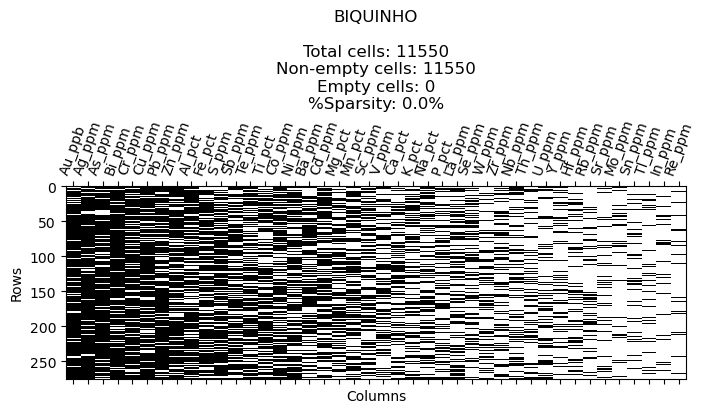

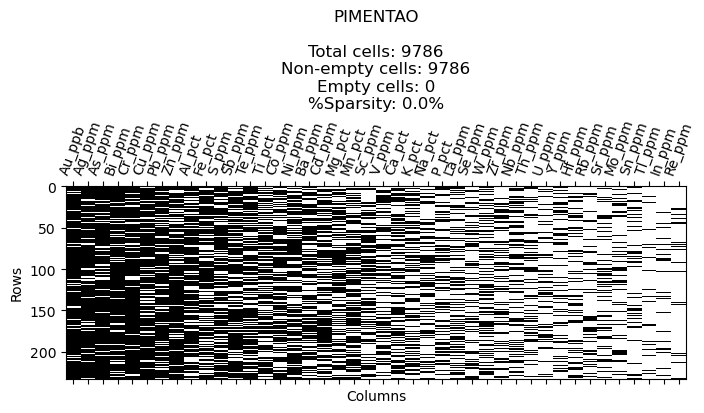

In [184]:
# Import required libraries
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import re  # For formatting feature names with subscripts

# --- Identify unique geological bodies in the sparsified dataset ---

# Extract all unique values from the 'Body' column
# Each value represents a distinct geological unit or zone
targets = df_sparse["Body"].unique()

# --- Loop over each body to visualize its sparsity pattern ---

for target in targets:
    title = str(target)  # Convert the body identifier to string for use in plot titles

    # Filter the sparse DataFrame to include only rows for the current body
    df2 = df_sparse[df_sparse["Body"] == target].copy()

    # --- Select only float-type columns for sparsity visualization ---

    # These are typically the numerical geochemical features
    df2 = df2.select_dtypes(include=['float'])

    # Drop location-related or non-feature columns if present
    # 'errors="ignore"' prevents errors if these columns are missing
    df2 = df2.drop(columns=['latitude', 'longitude', 'TA'], errors='ignore')

    # --- Prepare the data matrix for plotting ---

    # Convert the DataFrame to a NumPy array for visualization
    matrix = df2.values

    # Count the number of non-empty (non-zero) cells
    non_empty_cells = np.count_nonzero(matrix)

    # Calculate the number of empty (NaN) or zero cells
    empty_cells = matrix.size - non_empty_cells

    # Compute the sparsity percentage (proportion of empty cells)
    sparsity = round(empty_cells / matrix.size * 100, 1)

    # --- Format tick labels with subscripts for element names (e.g., 'Pb1' → 'Pb$_{1}$') ---

    my_ticks = list(range(len(df2.columns)))  # X-axis tick positions
    formatted_ticklabels = [
        re.sub(r'(\d+)', r'$_{\1}$', col) for col in df2.columns
    ]  # Format tick labels

    # --- Plot the sparsity pattern using a spy plot ---

    fig = plt.figure(figsize=(8, 2.5))  # Set figure size
    ax = fig.add_subplot(111)  # Create subplot
    plt.spy(matrix)  # Visualize the sparsity pattern (non-zero values shown as dots)
    ax.set_aspect('auto')  # Let the plot auto-adjust its aspect ratio

    # Set formatted feature names as x-axis labels
    plt.xticks(my_ticks, formatted_ticklabels, rotation=70)
    plt.xlabel('Columns')  # Label for features
    plt.ylabel('Rows')  # Label for samples

    # Set the plot title with detailed sparsity info
    ax.set_title(
        f"{title}\n\nTotal cells: {matrix.size}"
        f"\nNon-empty cells: {non_empty_cells}"
        f"\nEmpty cells: {empty_cells}"
        f"\n%Sparsity: {sparsity}%"
    )

    # Show the plot
    plt.show()


#Data Imputation
Data imputation is a technique used to handle missing values in datasets. It involves substituting the missing or null data points with substituted values, allowing for the continued use of the dataset for analysis without simply discarding incomplete records.

Iterative imputation is a specific method of imputation that models each feature with missing values as a function of other features in a round-robin fashion. It's a type of multivariate imputation that estimates the missing values within each feature by treating it as a target variable in a regression, with the other features as predictors. Here's how iterative imputation generally works:

1. Initially, all missing values are filled with some initial guess, which could be mean, median, or mode of the column.
2. The imputer then models each feature with missing values as a dependent variable, using the other features to predict the missing values.
3. This is done in a round-robin or cyclic order, where each feature is imputed in turn and used as a predictor for the next feature to be imputed.
4. The process iterates over the dataset multiple times until the change in imputed values converges or until a maximum number of iterations is reached.

Using the `IterativeImputer` from scikit-learn, the process can be fine-tuned with parameters like `max_iter` to set the maximum number of imputation iterations, `random_state` for reproducibility of results, and `min_value` or `max_value` to constrain imputed values. After imputation, the data is often more suitable for analysis, as it no longer contains gaps that could skew the results or prevent certain types of computations.

In [185]:
# --- Import necessary libraries ---

from sklearn.experimental import enable_iterative_imputer  # Enables experimental IterativeImputer
from sklearn.impute import IterativeImputer  # For advanced multivariate imputation
from tqdm import tqdm  # For displaying progress bars in loops
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import warnings  # For suppressing warnings

# Make a working copy of the combined dataset
df_combined_plot2 = df_combined

# Suppress warnings to keep output clean (e.g., convergence warnings from the imputer)
warnings.filterwarnings('ignore')

# --- Initialize the Iterative Imputer ---

# Set max_iter=10 for up to 10 rounds of imputation
# random_state=0 for reproducibility
# min_value=0 ensures no negative imputed values (suitable for geochemical data)
imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0)

# Prepare an empty list to store each body's imputed DataFrame
dfs_imputed = []

# --- Loop through each unique geological Body in the sparse dataset ---

# tqdm adds a progress bar to monitor processing
for body_value in tqdm(df_sparse['Body'].unique(), desc='Imputing by Body'):

    # Extract rows for the current Body group
    df = df_sparse[df_sparse['Body'] == body_value].copy()

    # --- Select float-type columns for imputation ---

    # These are typically the numerical features (e.g., element concentrations)
    df_float = df.select_dtypes(include=['float'])

    # Identify columns where *all* values are missing (imputer can't handle these)
    columns_with_all_nan = df_float.columns[df_float.isna().all()].tolist()

    # Temporarily replace all-NaN columns with a placeholder value (-1)
    # This allows the imputer to process the full DataFrame structure
    if columns_with_all_nan:
        df_float[columns_with_all_nan] = df_float[columns_with_all_nan].fillna(-1)

    # --- Apply the Iterative Imputer ---

    # Perform multivariate imputation on the float-only DataFrame
    df_imputed_array = imputer.fit_transform(df_float)

    # Convert the resulting NumPy array back to a DataFrame with original column names
    df_float_imputed = pd.DataFrame(df_imputed_array, columns=df_float.columns)

    # Restore NaN values in columns that were originally entirely missing
    for col in columns_with_all_nan:
        df_float_imputed[col] = df_float_imputed[col].replace(-1, np.nan)

    # --- Reconstruct the full DataFrame ---

    # Extract the non-float columns (e.g., 'index', 'Sample', 'Body')
    df_non_float = df.drop(columns=df_float.columns)

    # Concatenate imputed float columns with original non-float columns
    df_combined_plot2 = pd.concat([df_non_float.reset_index(drop=True), df_float_imputed], axis=1)

    # Append the fully imputed DataFrame for this Body group to the list
    dfs_imputed.append(df_combined_plot2)

# --- Combine all imputed Body-level DataFrames into one ---

# Reset the index in the final combined DataFrame
df_imputed = pd.concat(dfs_imputed, ignore_index=True)


Imputing by Body: 100%|███████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


In [186]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

In [187]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

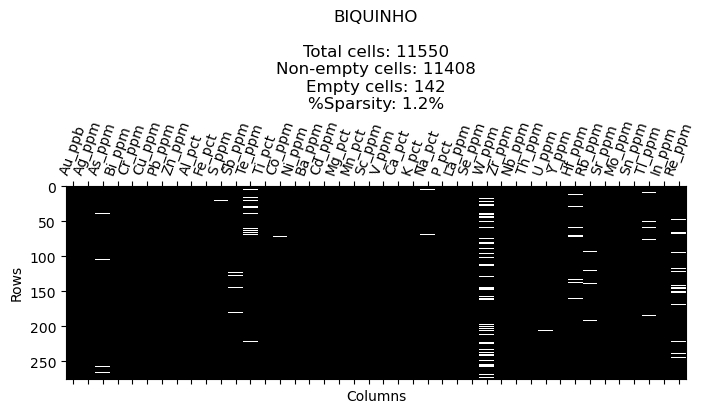

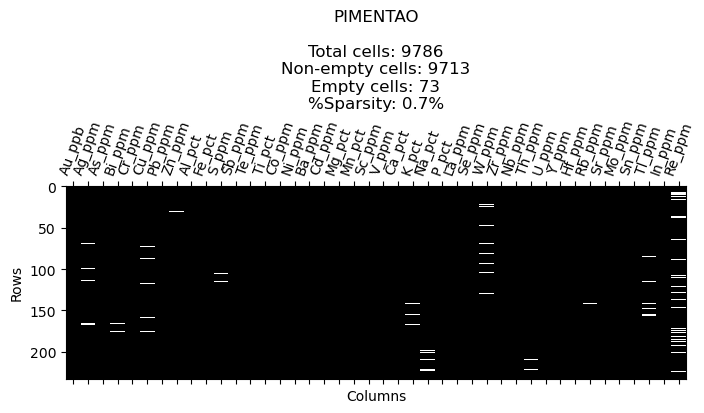

In [ ]:

# --- Identify unique geological bodies in the imputed dataset ---

# Get a list of unique 'Body' values from the imputed DataFrame
targets = df_imputed["Body"].unique()

# --- Loop through each body to visualize the sparsity pattern (post-imputation) ---

for target in targets:
    title = str(target)  # Convert the body label to string for use in plot titles

    # Filter the imputed DataFrame for rows corresponding to the current body
    df2 = df_imputed[df_imputed["Body"] == target].copy()

    # --- Select only float-type columns for visualization ---

    # This excludes metadata like 'index', 'Sample', or other categorical data
    df2 = df2.select_dtypes(include=['float'])

    # Drop optional location-related or unnecessary columns if they exist
    df2 = df2.drop(columns=['latitude', 'longitude', 'TA'], errors='ignore')

    # --- Prepare data for visualization ---

    # Convert the DataFrame to a NumPy matrix for plotting
    matrix = df2.values

    # Count the number of non-zero (i.e., non-empty or non-zero) cells
    non_empty_cells = np.count_nonzero(matrix)

    # Calculate the number of empty cells by subtracting from total matrix size
    empty_cells = matrix.size - non_empty_cells

    # Calculate the sparsity percentage (even though the data is now imputed)
    sparsity = round(empty_cells / matrix.size * 100, 1)

    # --- Set axis ticks and format column labels with subscripts ---

    # X-axis tick positions based on number of columns
    my_ticks = list(range(len(df2.columns)))

    # Format feature names to show numbers as subscripts (e.g., 'Pb1' → 'Pb$_{1}$')
    formatted_ticklabels = [
        re.sub(r'(\d+)', r'$_{\1}$', col) for col in df2.columns
    ]

    # --- Plot the sparsity pattern using a spy plot ---

    fig = plt.figure(figsize=(8, 2.5))  # Set the size of the figure
    ax = fig.add_subplot(111)  # Add a subplot to the figure

    plt.spy(matrix)  # Create a spy plot showing positions of non-zero elements
    ax.set_aspect('auto')  # Allow the aspect ratio to adjust automatically

    # Set x-ticks using formatted labels
    plt.xticks(my_ticks, formatted_ticklabels, rotation=70)

    # Label axes
    plt.xlabel('Columns')  # Feature names
    plt.ylabel('Rows')  # Sample indices

    # Add a detailed title showing basic matrix statistics
    ax.set_title(
        f"{title}\n\nTotal cells: {matrix.size}"
        f"\nNon-empty cells: {non_empty_cells}"
        f"\nEmpty cells: {empty_cells}"
        f"\n%Sparsity: {sparsity}%"
    )

    # Display the plot
    plt.show()


In [189]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

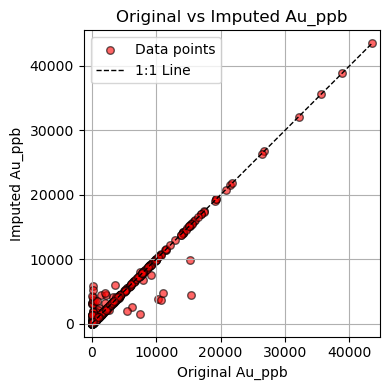

In [ ]:

# --- Extract original and imputed values for a specific feature (Au_ppb) ---

# Get the 'Au_ppb' column from the original combined DataFrame
original = df_combined["Au_ppb"]

# Get the corresponding 'Au_ppb' column from the imputed DataFrame
imputed = df_imputed["Au_ppb"]

# --- Set visual parameters for the scatter plot ---

symbol_size = 30  # Controls the size of the scatter plot markers

# --- Create the plot ---

plt.figure(figsize=(4, 4))  # Set figure size (width, height in inches)

# Optional: A hexbin or contour background could be added here (currently skipped)

# --- Plot the comparison between original and imputed values ---

# Create a scatter plot of original vs. imputed values
# Red markers with black edges, slightly transparent
plt.scatter(
    original, imputed,
    c='red', s=symbol_size,
    alpha=0.6, edgecolor='k',
    label='Data points'
)

# --- Add a dashed 1:1 reference line ---

# Define axis limits based on the min and max of both datasets
lims = [
    np.min([original.min(), imputed.min()]),
    np.max([original.max(), imputed.max()])
]

# Plot a dashed line (y = x) to indicate perfect agreement
plt.plot(lims, lims, 'k--', linewidth=1, label='1:1 Line')

# --- Add plot labels, legend, and formatting ---

plt.xlabel('Original Au_ppb')  # X-axis label
plt.ylabel('Imputed Au_ppb')  # Y-axis label
plt.title('Original vs Imputed Au_ppb')  # Title of the plot
plt.legend()  # Show legend
plt.axis('equal')  # Set the same scale for both axes
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot


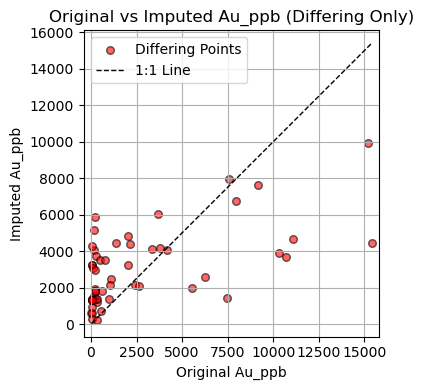

In [ ]:
# --- Extract original and imputed Au_ppb values ---

# Get the 'Au_ppb' values from the original combined dataset
original = df_combined["Au_ppb"]

# Get the 'Au_ppb' values from the imputed dataset
imputed = df_imputed["Au_ppb"]

# --- Identify values that changed after imputation ---

# Create a boolean mask where values differ between the original and imputed columns
mask = original != imputed

# Apply the mask to get only the differing original and imputed values
original_diff = original[mask]
imputed_diff = imputed[mask]

# --- Set visual parameters for plotting ---

symbol_size = 30  # Size of scatter plot markers

# --- Create the plot ---

plt.figure(figsize=(4, 4))  # Set figure size

# Plot only the values that changed after imputation
plt.scatter(
    original_diff, imputed_diff,
    c='red', s=symbol_size,
    alpha=0.6, edgecolor='k',
    label='Differing Points'  # Legend label
)

# --- Add a 1:1 reference line for visual comparison ---

# Determine min and max values for setting axis limits
lims = [
    np.min([original_diff.min(), imputed_diff.min()]),
    np.max([original_diff.max(), imputed_diff.max()])
]

# Plot a dashed black line (y = x) to represent perfect agreement
plt.plot(lims, lims, 'k--', linewidth=1, label='1:1 Line')

# --- Add labels, legend, and formatting ---

plt.xlabel('Original Au_ppb')  # Label for x-axis
plt.ylabel('Imputed Au_ppb')  # Label for y-axis
plt.title('Original vs Imputed Au_ppb (Differing Only)')  # Title of the plot
plt.legend()  # Display the legend
plt.axis('equal')  # Keep the x and y axis scales equal
plt.grid(True)  # Add gridlines for better readability
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()  # Display the plot


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


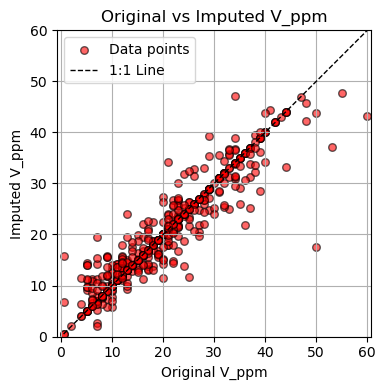

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Not used in this specific snippet but imported in case needed

# Extract the original and imputed V_ppm values from two dataframes
original = df_combined["V_ppm"]   # Original (non-imputed) data
imputed = df_imputed["V_ppm"]     # Imputed (filled) data

# Set the size for scatter plot symbols
symbol_size = 30  # You can adjust this for larger/smaller point size

# Create a new figure with specified dimensions
plt.figure(figsize=(4, 4))

# Plot a scatter plot comparing original vs imputed values
plt.scatter(
    original, imputed,
    c='red',                 # Red color for points
    s=symbol_size,          # Size of symbols
    alpha=0.6,              # Transparency
    edgecolor='k',          # Black edge for points
    label='Data points'     # Legend label
)

# Define limits for the 1:1 reference line based on min/max of both datasets
lims = [
    np.min([original.min(), imputed.min()]),
    np.max([original.max(), imputed.max()])
]

# Plot a dashed 1:1 line (where original = imputed)
plt.plot(
    lims, lims,
    'k--',                 # Black dashed line
    linewidth=1,
    label='1:1 Line'       # Legend label
)

# Add axis labels and plot title
plt.xlabel('Original V_ppm')
plt.ylabel('Imputed V_ppm')
plt.title('Original vs Imputed V_ppm')

# Show legend
plt.legend()

# Set equal scaling on both axes
plt.axis('equal')

# Add grid for readability
plt.grid(True)

# Use tight layout to prevent label cutoff
plt.tight_layout()

# Set fixed axis limits
plt.xlim(0, 60)
plt.ylim(0, 60)

# Display the plot
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


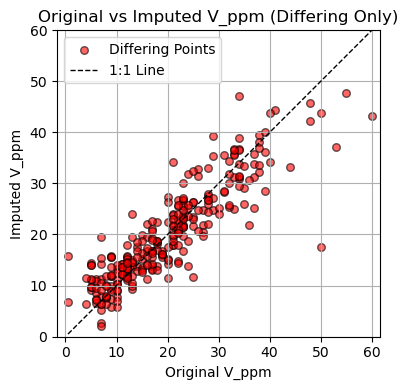

In [203]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Included in case additional visualization is needed later

# Extract the 'V_ppm' column from both the original and imputed DataFrames
original = df_combined["V_ppm"]   # Original values before imputation
imputed = df_imputed["V_ppm"]     # Values after imputation

# Create a boolean mask where the original and imputed values differ
mask = original != imputed

# Apply the mask to extract only the differing values from both series
original_diff = original[mask]
imputed_diff = imputed[mask]

# Set the symbol size for the scatter plot points
symbol_size = 30  # Adjust this for larger or smaller dots

# Create a new figure with a fixed size
plt.figure(figsize=(4, 4))

# Plot a scatter plot for the values that differ between original and imputed
plt.scatter(
    original_diff, imputed_diff,
    c='red',                # Red color for visibility
    s=symbol_size,          # Point size
    alpha=0.6,              # Slight transparency
    edgecolor='k',          # Black edge around each point
    label='Differing Points'  # Label for the legend
)

# Define the limits for the plot based on the min and max of both series
lims = [
    np.min([original_diff.min(), imputed_diff.min()]),
    np.max([original_diff.max(), imputed_diff.max()])
]

# Plot a dashed 1:1 reference line (ideal line where original = imputed)
plt.plot(
    lims, lims,
    'k--',                 # Black dashed line
    linewidth=1,
    label='1:1 Line'       # Label for the legend
)

# Add axis labels and a title to the plot
plt.xlabel('Original V_ppm')
plt.ylabel('Imputed V_ppm')
plt.title('Original vs Imputed V_ppm (Differing Only)')

# Show the legend (includes scatter and 1:1 line)
plt.legend()

# Set both axes to the same scale for fair comparison
plt.axis('equal')

# Add a background grid for visual reference
plt.grid(True)

# Use tight layout to make sure labels don't get cut off
plt.tight_layout()

# Manually fix x and y axis limits (can be adjusted if needed)
plt.xlim(0, 60)
plt.ylim(0, 60)

# Display the plot
plt.show()


In [204]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   508 non-null    int64  
 1   Body    508 non-null    object 
 2   Sample  508 non-null    object 
 3   Au_ppb  508 non-null    float64
 4   Ag_ppm  508 non-null    float64
 5   As_ppm  508 non-null    float64
 6   Bi_ppm  508 non-null    float64
 7   Cr_ppm  508 non-null    float64
 8   Cu_ppm  508 non-null    float64
 9   Pb_ppm  508 non-null    float64
 10  Zn_ppm  508 non-null    float64
 11  Al_pct  508 non-null    float64
 12  Fe_pct  508 non-null    float64
 13  S_ppm   508 non-null    float64
 14  Sb_ppm  508 non-null    float64
 15  Te_ppm  508 non-null    float64
 16  Ti_pct  508 non-null    float64
 17  Co_ppm  508 non-null    float64
 18  Ni_ppm  508 non-null    float64
 19  Ba_ppm  508 non-null    float64
 20  Cd_ppm  508 non-null    float64
 21  Mg_pct  508 non-null    float64
 22  Mn

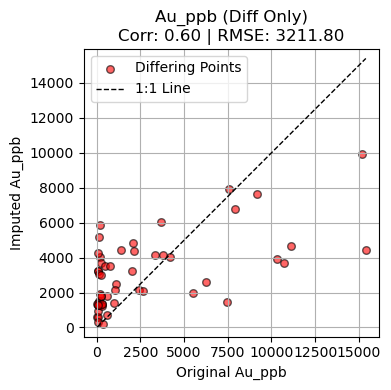

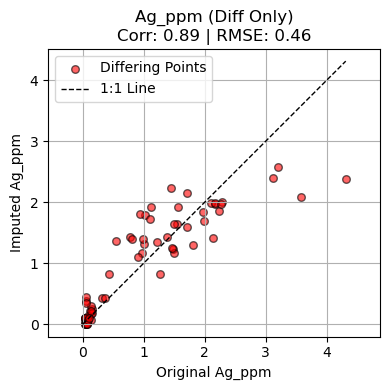

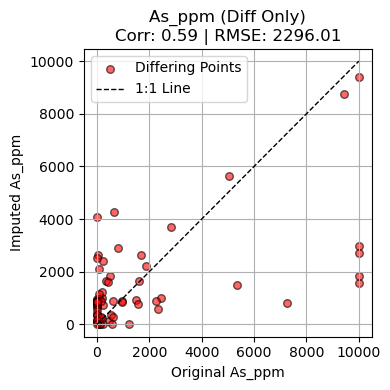

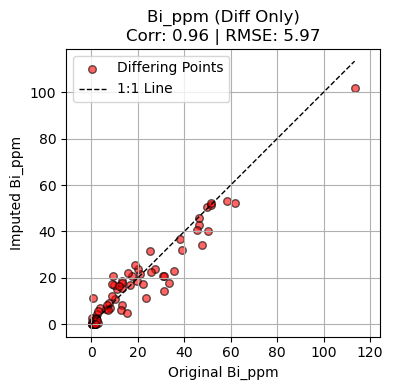

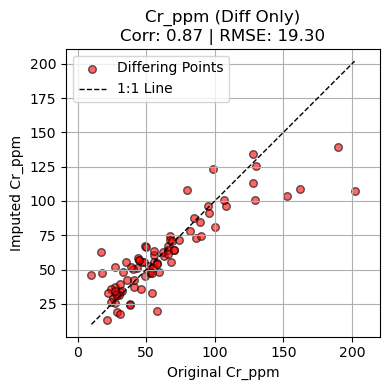

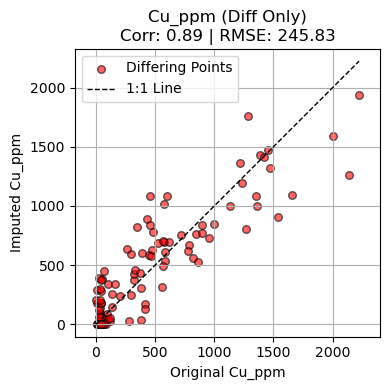

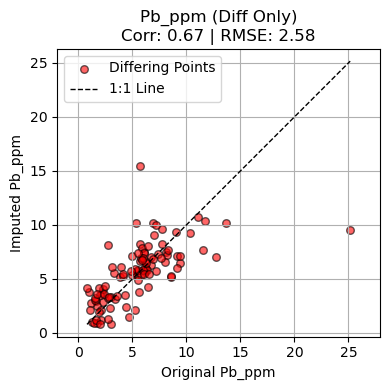

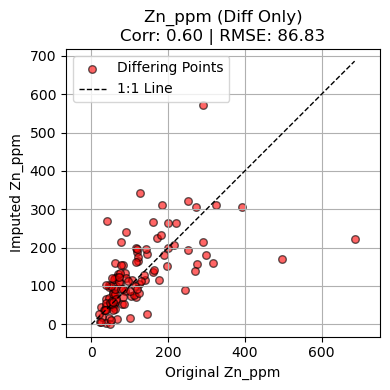

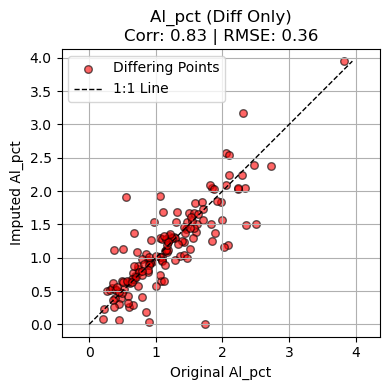

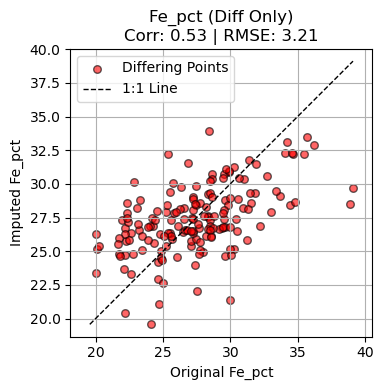

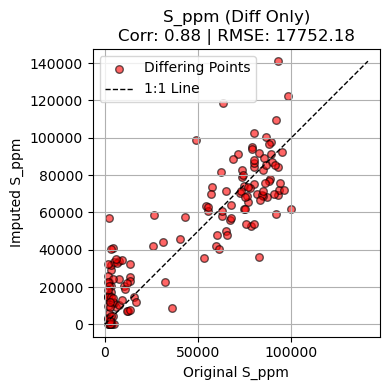

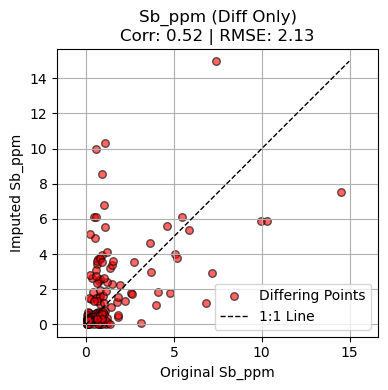

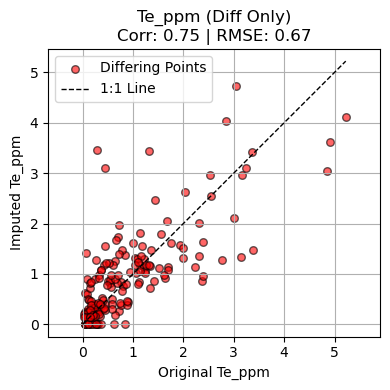

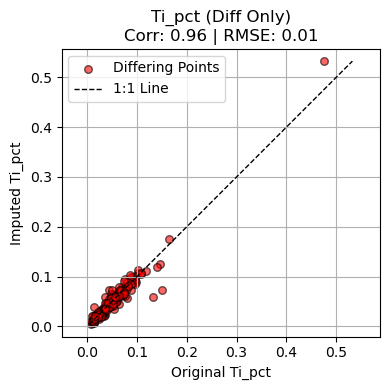

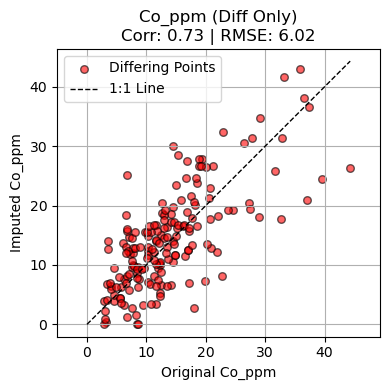

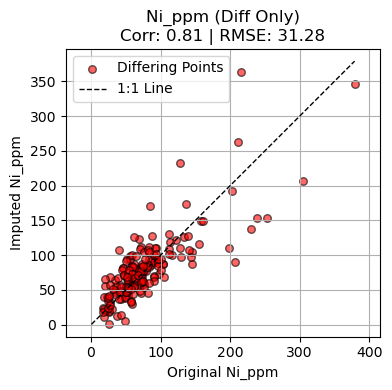

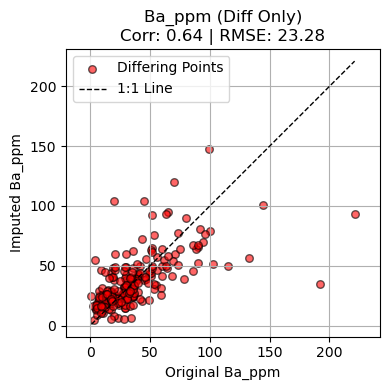

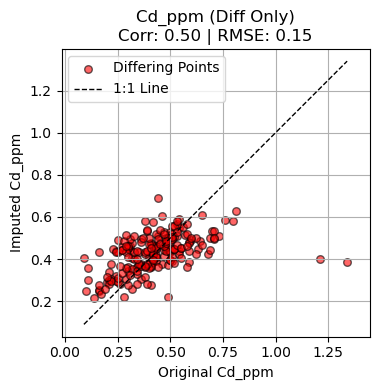

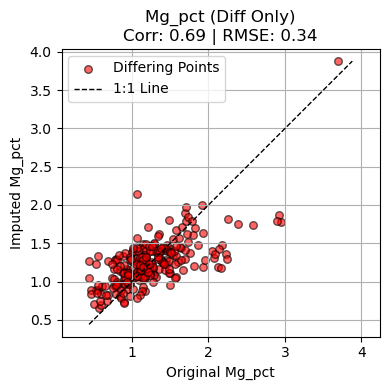

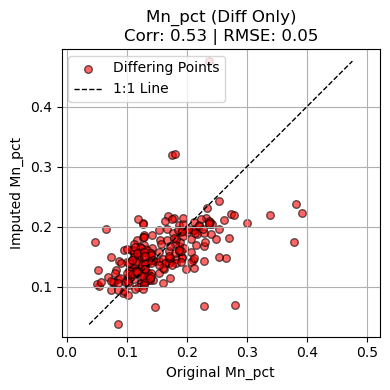

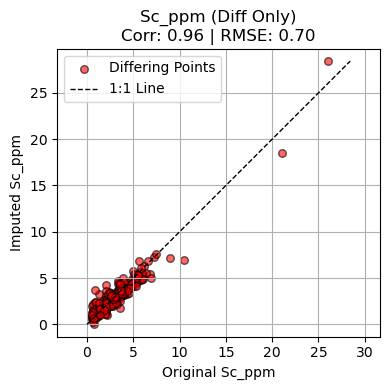

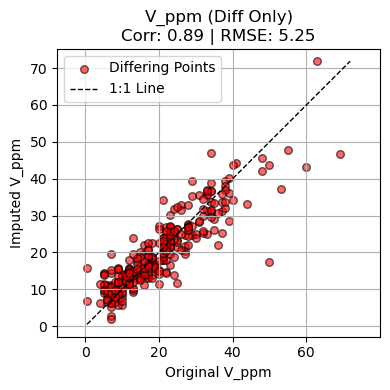

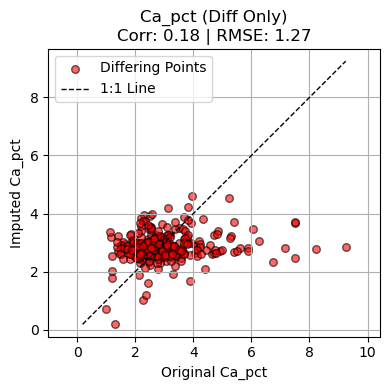

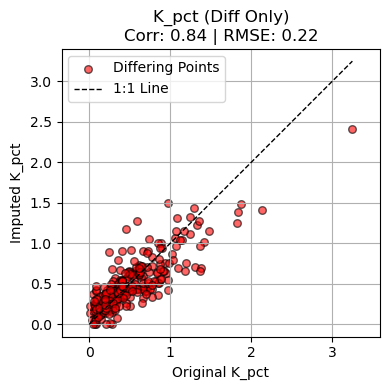

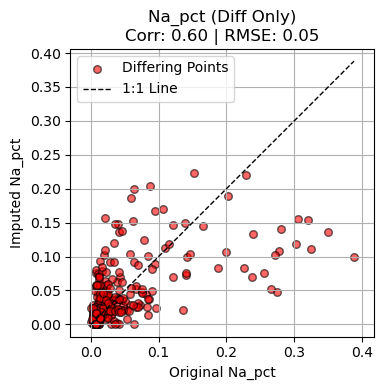

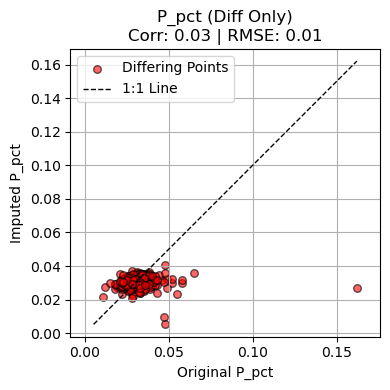

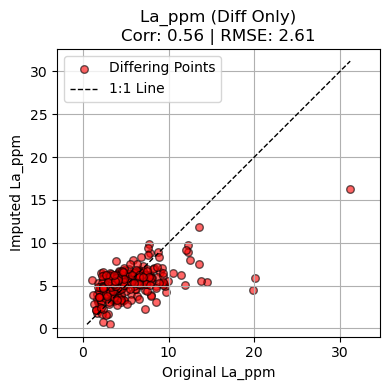

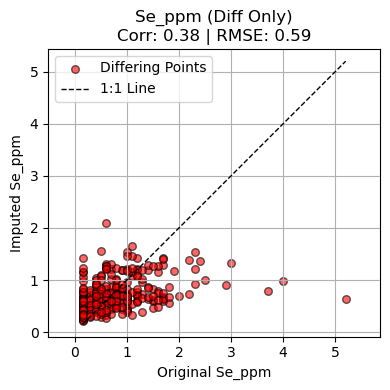

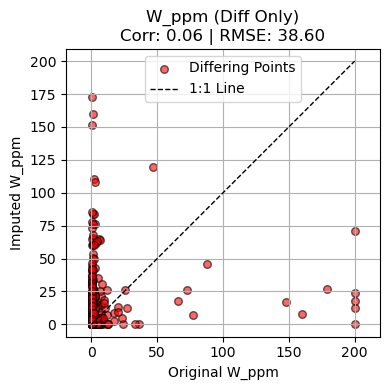

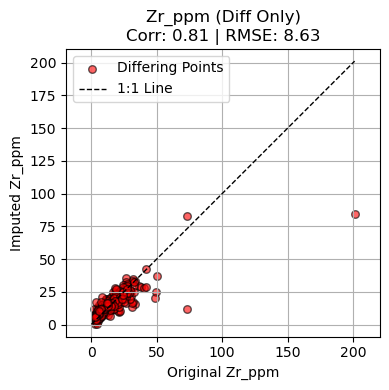

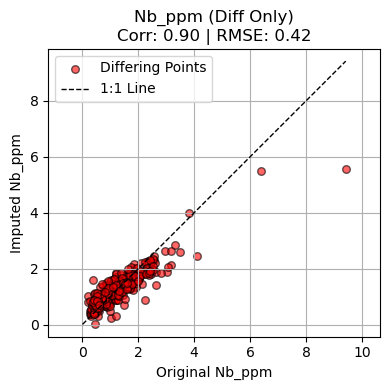

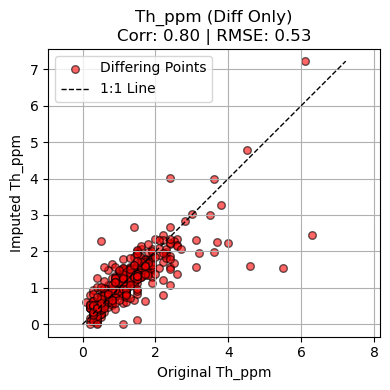

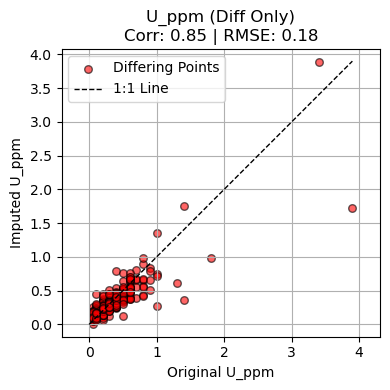

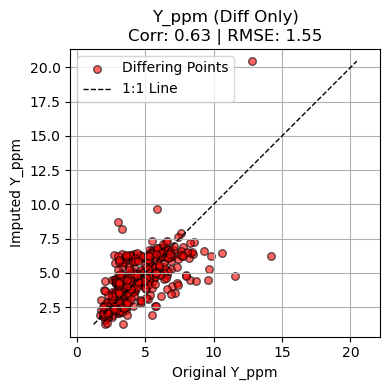

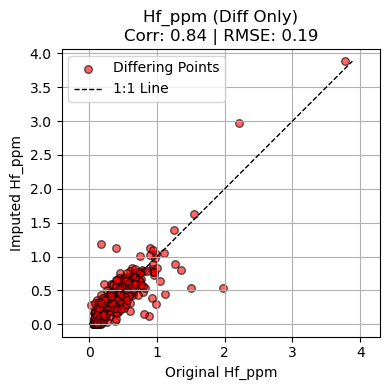

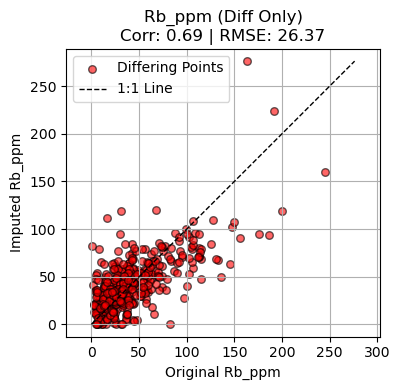

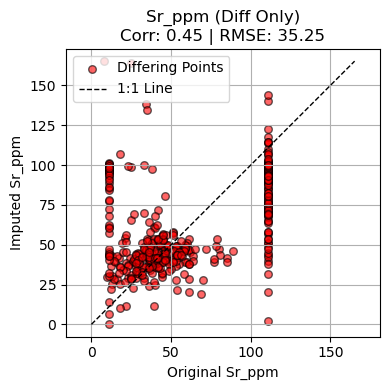

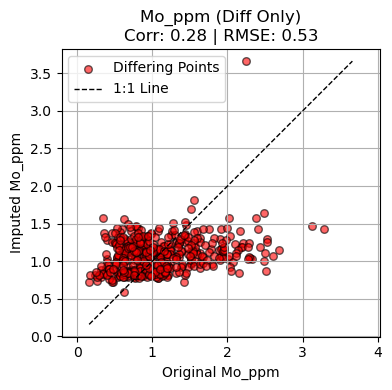

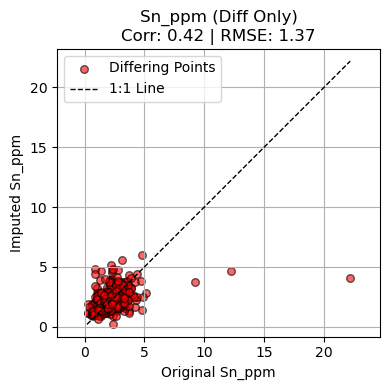

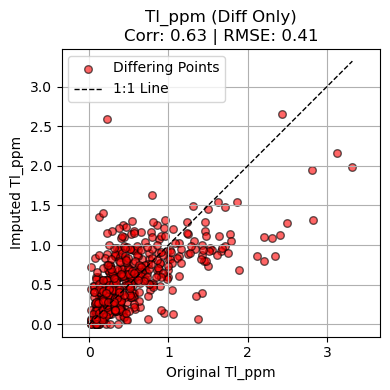

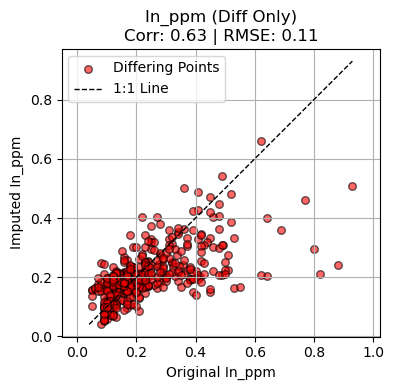

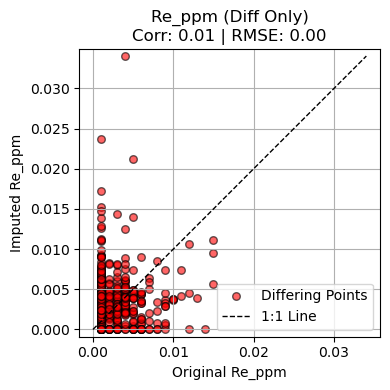

Correlation and RMSE Summary (for differing values only):
   Feature  Correlation          RMSE
13  Ti_pct     0.964317      0.011808
3   Bi_ppm     0.960339      5.971986
20  Sc_ppm     0.959176      0.700276
30  Nb_ppm     0.895653      0.416914
21   V_ppm     0.889895      5.247506
1   Ag_ppm     0.888592      0.464958
5   Cu_ppm     0.887012    245.827795
10   S_ppm     0.878580  17752.178880
4   Cr_ppm     0.871240     19.297070
32   U_ppm     0.854866      0.175019
23   K_pct     0.841039      0.220687
34  Hf_ppm     0.838255      0.186630
8   Al_pct     0.834224      0.358274
29  Zr_ppm     0.809775      8.632091
15  Ni_ppm     0.807167     31.284613
31  Th_ppm     0.798473      0.533418
12  Te_ppm     0.751967      0.672603
14  Co_ppm     0.728359      6.019823
35  Rb_ppm     0.694686     26.367562
18  Mg_pct     0.693745      0.338509
6   Pb_ppm     0.668460      2.576349
16  Ba_ppm     0.635461     23.276558
33   Y_ppm     0.631797      1.545261
39  Tl_ppm     0.630215      0

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pandas as pd

# Columns to exclude from analysis
exclude_cols = ['index', 'Body', 'Sample']

# Identify numeric feature columns to process
features = [
    col for col in df_combined.columns
    if col in df_imputed.columns and col not in exclude_cols
    and pd.api.types.is_numeric_dtype(df_combined[col])
]

# Prepare list to hold results
results = []

# Loop through each feature
for feature in features:
    # Get original and imputed values
    original = df_combined[feature]
    imputed = df_imputed[feature]

    # Mask where values differ
    mask = original != imputed
    original_diff = original[mask]
    imputed_diff = imputed[mask]

    # Skip if no differences
    if original_diff.empty or imputed_diff.empty:
        continue

    # Compute correlation coefficient
    corr = original_diff.corr(imputed_diff)

    # Compute dispersion: RMSE
    rmse = np.sqrt(mean_squared_error(original_diff, imputed_diff))

    # Append result
    results.append({'Feature': feature, 'Correlation': corr, 'RMSE': rmse})

    # Optional: plot
    plt.figure(figsize=(4, 4))
    plt.scatter(original_diff, imputed_diff, c='red', s=30, alpha=0.6,
                edgecolor='k', label='Differing Points')

    lims = [
        np.min([original_diff.min(), imputed_diff.min()]),
        np.max([original_diff.max(), imputed_diff.max()])
    ]
    plt.plot(lims, lims, 'k--', linewidth=1, label='1:1 Line')

    plt.xlabel(f'Original {feature}')
    plt.ylabel(f'Imputed {feature}')
    plt.title(f'{feature} (Diff Only)\nCorr: {corr:.2f} | RMSE: {rmse:.2f}')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create summary table
results_df = pd.DataFrame(results).sort_values(by='Correlation', ascending=False)

# Display the table
print("Correlation and RMSE Summary (for differing values only):")
print(results_df)

# Optional: save to CSV
# results_df.to_csv("correlation_rmse_summary.csv", index=False)


# Random Forest using original dataset

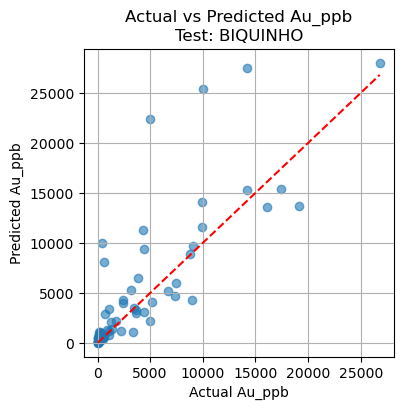

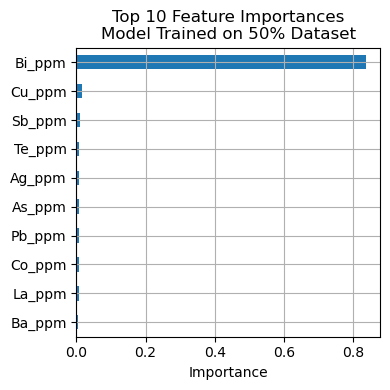

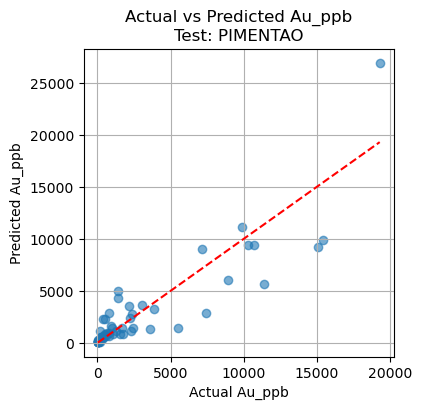

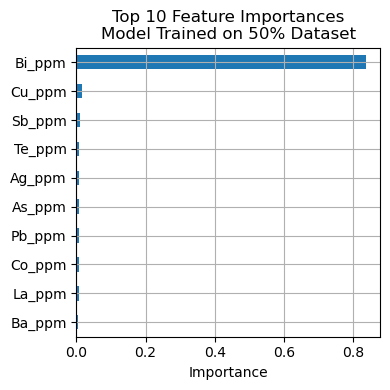

In [205]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Check if df_combined is defined and contains required columns
try:
    if 'Body' in df_combined.columns and 'Au_ppb' in df_combined.columns:
        # Drop rows where 'Au_ppb' or 'Body' are missing
        df_filtered = df_combined.dropna(subset=['Au_ppb', 'Body']).reset_index(drop=True)

        # If 'index' is a column in the DataFrame (not the actual index), remove it
        if 'index' in df_filtered.columns:
            df_filtered = df_filtered.drop(columns=['index'])

        # Split the dataset randomly into two halves: 50% training, 50% holdout
        train_df, holdout_df = train_test_split(df_filtered, test_size=0.5, random_state=42)

        # Extract a balanced test set: 50% of the holdout data for each unique 'Body'
        bodies = holdout_df['Body'].unique()
        test_sets = {}
        for body in bodies:
            subset = holdout_df[holdout_df['Body'] == body]
            if len(subset) >= 2:
                # Take a 50% random sample from each body's data
                test_sets[body] = subset.sample(frac=0.5, random_state=42)

        # Separate features and target variable for training
        X_train = train_df.drop(columns=['Au_ppb'])
        y_train = train_df['Au_ppb']

        # One-hot encode categorical variables
        X_train = pd.get_dummies(X_train)

        # Fill any remaining NaN values in features with the column mean
        X_train = X_train.fillna(X_train.mean())

        # Initialize and train a Random Forest Regressor on the training data
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Evaluate the trained model on each per-body test set
        for body_name, test_df in test_sets.items():
            # Separate features and target variable for test set
            X_test = test_df.drop(columns=['Au_ppb'])
            y_test = test_df['Au_ppb']

            # One-hot encode the test set to match training structure
            X_test = pd.get_dummies(X_test)

            # Align test features with training features (fill missing cols with 0)
            X_train_aligned, X_test_aligned = X_train.align(X_test, join='left', axis=1, fill_value=0)

            # Fill any NaN values in the aligned test set with training column means
            X_test_aligned = X_test_aligned.fillna(X_train.mean())

            # Predict 'Au_ppb' using the trained model
            y_pred = model.predict(X_test_aligned)

            # Plot actual vs predicted 'Au_ppb' for this body
            plt.figure(figsize=(4, 4))
            plt.scatter(y_test, y_pred, alpha=0.6)
            plt.plot(
                [y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--'  # Red dashed 1:1 reference line
            )
            plt.xlabel("Actual Au_ppb")
            plt.ylabel("Predicted Au_ppb")
            plt.title(f"Actual vs Predicted Au_ppb\nTest: {body_name}")
            plt.grid(True)
            plt.show()

            # Compute and display the top 10 most important features from the model
            feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            top_features = feature_importances.sort_values(ascending=False).head(10)

            # Plot horizontal bar chart of top feature importances
            plt.figure(figsize=(4, 4))
            top_features.plot(kind='barh')
            plt.gca().invert_yaxis()  # Show most important features at the top
            plt.xlabel("Importance")
            plt.title("Top 10 Feature Importances\nModel Trained on 50% Dataset")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    else:
        # Inform the user if required columns are missing
        print("Required columns 'Body' or 'Au_ppb' not found in the dataset.")
except NameError:
    # Inform the user if df_combined hasn't been defined at all
    print("The dataset 'df_combined' is not defined. Please upload it.")


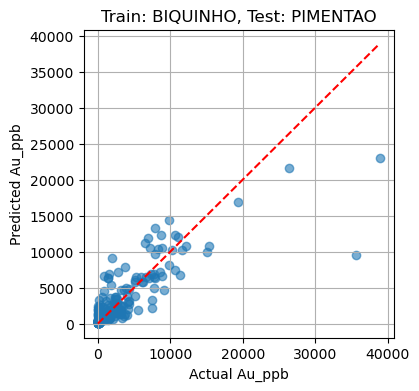

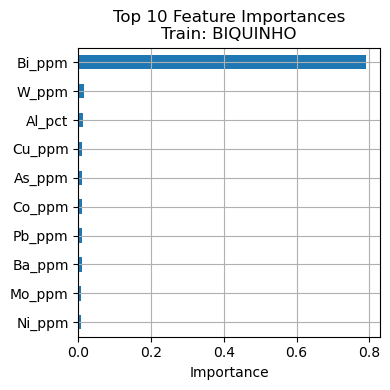

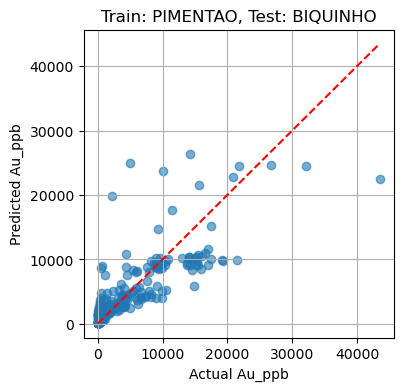

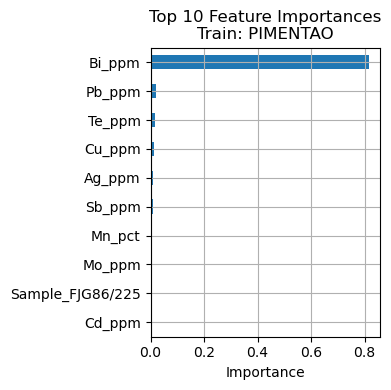

In [206]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Check if the dataset 'df_combined' exists and contains required columns
try:
    if 'Body' in df_combined.columns and 'Au_ppb' in df_combined.columns:
        # Remove rows where either 'Body' or 'Au_ppb' is missing, and reset index
        df_filtered = df_combined.dropna(subset=['Au_ppb', 'Body']).reset_index(drop=True)

        # Drop the 'index' column if it exists (to avoid it being used as a feature)
        if 'index' in df_filtered.columns:
            df_filtered = df_filtered.drop(columns=['index'])

        # Get all unique body names from the 'Body' column (excluding NaNs)
        bodies = df_filtered['Body'].dropna().unique()

        # Check if there are at least two unique bodies to perform cross-body training
        if len(bodies) >= 2:
            body_name_1 = bodies[0]  # Select the first body
            body_name_2 = bodies[1]  # Select the second body

            # Define a reusable function to train on one body and test on another
            def train_and_predict(train_body, test_body, train_name, test_name):
                # Filter the training and testing data based on body name
                train_df = df_filtered[df_filtered['Body'] == train_body]
                test_df = df_filtered[df_filtered['Body'] == test_body]

                # Separate features and target variable for training and testing
                X_train = train_df.drop(columns=['Au_ppb'])
                y_train = train_df['Au_ppb']
                X_test = test_df.drop(columns=['Au_ppb'])
                y_test = test_df['Au_ppb']

                # Convert categorical variables to dummy/indicator variables
                X_train = pd.get_dummies(X_train)
                X_test = pd.get_dummies(X_test)

                # Align test set to training columns (filling missing columns with 0)
                X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

                # Fill any missing values in features using column means from training set
                X_train = X_train.fillna(X_train.mean())
                X_test = X_test.fillna(X_train.mean())

                # Initialize and train the Random Forest model
                model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(X_train, y_train)

                # Predict on the test set
                y_pred = model.predict(X_test)

                # Plot actual vs predicted Au_ppb values for visual comparison
                plt.figure(figsize=(4, 4))
                plt.scatter(y_test, y_pred, alpha=0.6)
                plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 1:1 line
                plt.xlabel("Actual Au_ppb")
                plt.ylabel("Predicted Au_ppb")
                plt.title(f"Train: {train_name}, Test: {test_name}")
                plt.grid(True)
                plt.show()

                # Calculate and plot feature importances
                feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
                top_features = feature_importances.sort_values(ascending=False).head(10)

                # Horizontal bar plot of top 10 important features
                plt.figure(figsize=(4, 4))
                top_features.plot(kind='barh')
                plt.gca().invert_yaxis()  # Highest importance at the top
                plt.xlabel("Importance")
                plt.title(f"Top 10 Feature Importances\nTrain: {train_name}")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            # Train on Body 1, test on Body 2
            train_and_predict(body_name_1, body_name_2, body_name_1, body_name_2)

            # Train on Body 2, test on Body 1
            train_and_predict(body_name_2, body_name_1, body_name_2, body_name_1)

        else:
            # Not enough bodies to perform a cross-body test
            print("Not enough unique bodies to perform cross-validation.")
    else:
        # Required columns are missing from the DataFrame
        print("Required columns 'Body' or 'Au_ppb' not found in the dataset.")
except NameError:
    # 'df_combined' hasn't been defined or loaded
    print("The dataset 'df_combined' is not defined. Please upload it.")


# Random Forest using Imputed dataset

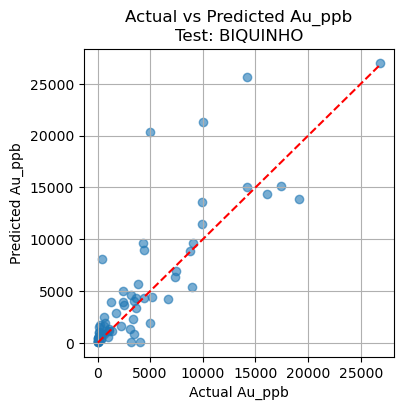

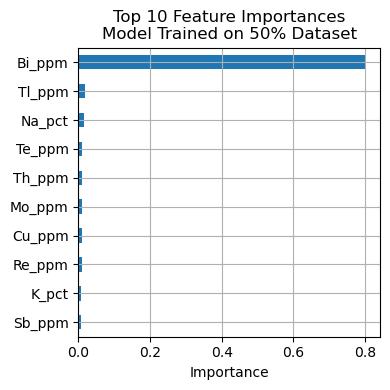

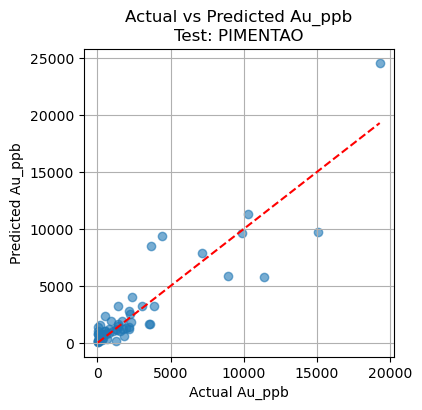

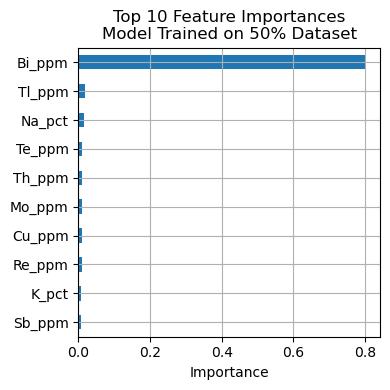

In [207]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Check if the df_imputed DataFrame exists and contains the required columns
try:
    if 'Body' in df_imputed.columns and 'Au_ppb' in df_imputed.columns:
        # Remove rows with missing values in 'Body' or 'Au_ppb' and reset the index
        df_filtered = df_imputed.dropna(subset=['Au_ppb', 'Body']).reset_index(drop=True)

        # Drop 'index' column if it exists (it could be a leftover from previous manipulations)
        if 'index' in df_filtered.columns:
            df_filtered = df_filtered.drop(columns=['index'])

        # Randomly split the filtered data into 50% training and 50% holdout sets
        train_df, holdout_df = train_test_split(df_filtered, test_size=0.5, random_state=42)

        # For each body in the holdout set, select 50% of its samples to use as test data
        bodies = holdout_df['Body'].unique()
        test_sets = {}  # Dictionary to store test samples for each body
        for body in bodies:
            subset = holdout_df[holdout_df['Body'] == body]
            if len(subset) >= 2:  # Only include bodies with at least 2 samples
                test_sets[body] = subset.sample(frac=0.5, random_state=42)

        # Prepare training features and target
        X_train = train_df.drop(columns=['Au_ppb'])  # Drop target column from training set
        y_train = train_df['Au_ppb']                 # Target variable for training

        # One-hot encode categorical features in training data
        X_train = pd.get_dummies(X_train)

        # Fill missing values with column means in training data
        X_train = X_train.fillna(X_train.mean())

        # Initialize and train a Random Forest regression model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Loop through each body-specific test set for evaluation
        for body_name, test_df in test_sets.items():
            # Prepare test features and target
            X_test = test_df.drop(columns=['Au_ppb'])
            y_test = test_df['Au_ppb']

            # One-hot encode test features
            X_test = pd.get_dummies(X_test)

            # Align test columns with training columns (adds missing ones with 0)
            X_train_aligned, X_test_aligned = X_train.align(X_test, join='left', axis=1, fill_value=0)

            # Fill any missing values in the test set with training column means
            X_test_aligned = X_test_aligned.fillna(X_train.mean())

            # Predict Au_ppb values using the trained model
            y_pred = model.predict(X_test_aligned)

            # Plot: Actual vs Predicted Au_ppb values
            plt.figure(figsize=(4, 4))
            plt.scatter(y_test, y_pred, alpha=0.6)
            plt.plot(
                [y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--'  # Red dashed 1:1 line
            )
            plt.xlabel("Actual Au_ppb")
            plt.ylabel("Predicted Au_ppb")
            plt.title(f"Actual vs Predicted Au_ppb\nTest: {body_name}")
            plt.grid(True)
            plt.show()

            # Get feature importances from the trained model
            feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            top_features = feature_importances.sort_values(ascending=False).head(10)

            # Plot: Top 10 most important features
            plt.figure(figsize=(4, 4))
            top_features.plot(kind='barh')  # Horizontal bar chart
            plt.gca().invert_yaxis()  # Highest importance at the top
            plt.xlabel("Importance")
            plt.title("Top 10 Feature Importances\nModel Trained on 50% Dataset")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    else:
        # If required columns are not found in df_imputed
        print("Required columns 'Body' or 'Au_ppb' not found in the dataset.")

# If df_imputed itself is not defined
except NameError:
    print("The dataset 'df_imputed' is not defined. Please upload it.")


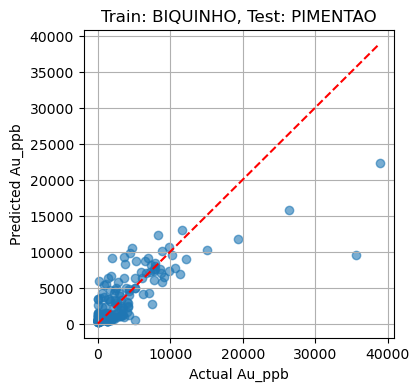

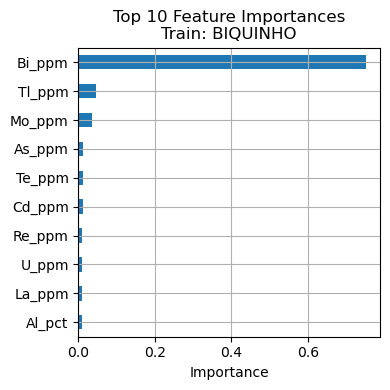

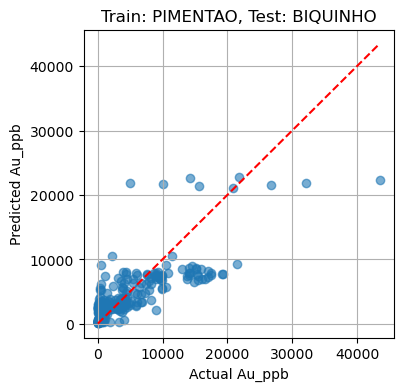

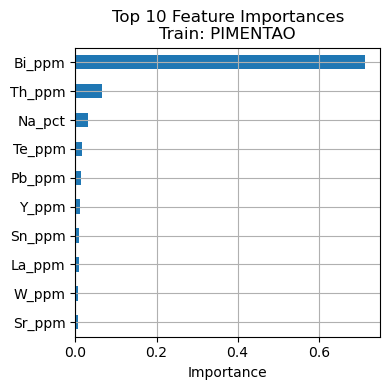

In [209]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Check if 'df_imputed' exists and contains the required columns
try:
    if 'Body' in df_imputed.columns and 'Au_ppb' in df_imputed.columns:

        # Drop rows where 'Body' or 'Au_ppb' are missing; reset index after dropping
        df_filtered = df_imputed.dropna(subset=['Au_ppb', 'Body']).reset_index(drop=True)

        # If 'index' exists as a column (not the actual index), remove it
        if 'index' in df_filtered.columns:
            df_filtered = df_filtered.drop(columns=['index'])

        # Get a list of unique body names
        bodies = df_filtered['Body'].dropna().unique()

        # Plot Au_ppb vs Bi_ppb for each body, if 'Bi_ppb' is present
        for body in bodies:
            subset = df_filtered[df_filtered['Body'] == body]
            if 'Bi_ppb' in subset.columns:
                # Create a scatter plot for Au_ppb vs Bi_ppb for the current body
                plt.figure()
                plt.scatter(subset['Bi_ppb'], subset['Au_ppb'], alpha=0.6)
                plt.title(f'Au_ppb vs Bi_ppb for Body: {body}')
                plt.xlabel('Bi_ppb')
                plt.ylabel('Au_ppb')
                plt.grid(True)
                plt.show()

        # Proceed only if there are at least two bodies for cross-body modeling
        if len(bodies) >= 2:
            # Select the first two unique bodies for training and testing
            body_name_1 = bodies[0]
            body_name_2 = bodies[1]

            # Define a function to train on one body and predict on another
            def train_and_predict(train_body, test_body, train_name, test_name):
                # Split data into training and testing sets based on body
                train_df = df_filtered[df_filtered['Body'] == train_body]
                test_df = df_filtered[df_filtered['Body'] == test_body]

                # Separate features and target
                X_train = train_df.drop(columns=['Au_ppb'])
                y_train = train_df['Au_ppb']
                X_test = test_df.drop(columns=['Au_ppb'])
                y_test = test_df['Au_ppb']

                # Convert categorical variables to one-hot encoded (dummy) variables
                X_train = pd.get_dummies(X_train)
                X_test = pd.get_dummies(X_test)

                # Align test features to match training features (fill missing columns with 0)
                X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

                # Fill any remaining missing values with the mean of each training feature
                X_train = X_train.fillna(X_train.mean())
                X_test = X_test.fillna(X_train.mean())

                # Initialize and train a Random Forest model
                model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(X_train, y_train)

                # Generate predictions for the test set
                y_pred = model.predict(X_test)

                # Plot predicted vs actual Au_ppb values
                plt.figure(figsize=(4, 4))
                plt.scatter(y_test, y_pred, alpha=0.6)
                plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 1:1 line
                plt.xlabel("Actual Au_ppb")
                plt.ylabel("Predicted Au_ppb")
                plt.title(f"Train: {train_name}, Test: {test_name}")
                plt.grid(True)
                plt.show()

                # Get feature importances from the trained model
                feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
                top_features = feature_importances.sort_values(ascending=False).head(10)

                # Plot the top 10 most important features
                plt.figure(figsize=(4, 4))
                top_features.plot(kind='barh')  # Horizontal bar chart
                plt.gca().invert_yaxis()  # Most important feature at the top
                plt.xlabel("Importance")
                plt.title(f"Top 10 Feature Importances\nTrain: {train_name}")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            # First run: train on Body 1, test on Body 2
            train_and_predict(body_name_1, body_name_2, body_name_1, body_name_2)

            # Second run: train on Body 2, test on Body 1
            train_and_predict(body_name_2, body_name_1, body_name_2, body_name_1)

        else:
            # If fewer than two unique bodies are found, print a message and stop
            print("Not enough unique bodies to perform cross-validation.")
    else:
        # If required columns are missing, notify the user
        print("Required columns 'Body' or 'Au_ppb' not found in the dataset.")

# Catch the case where df_imputed is not defined at all
except NameError:
    print("The dataset 'df_imputed' is not defined. Please upload it.")


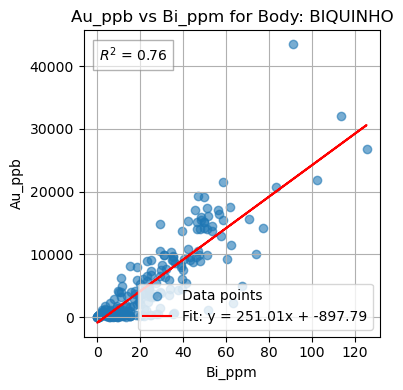

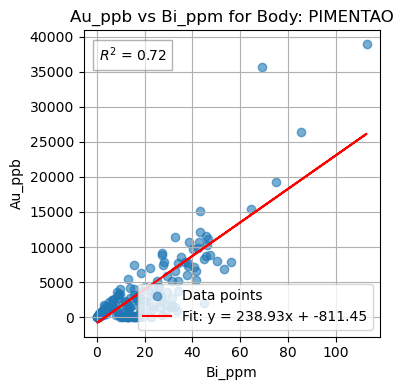

In [211]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Get the list of unique body names from the 'Body' column of the DataFrame
unique_bodies = df_combined['Body'].unique()

# Loop over each body to perform analysis and plotting individually
for body in unique_bodies:
    # Filter the dataset to only include rows belonging to the current body
    subset = df_combined[df_combined['Body'] == body]

    # Extract the Bi_ppm values (independent variable, x-axis)
    x = subset['Bi_ppm']

    # Extract the Au_ppb values (dependent variable, y-axis)
    y = subset['Au_ppb']

    # Create a mask to exclude rows with missing (NaN) values in either variable
    mask = x.notna() & y.notna()
    x = x[mask]
    y = y[mask]

    # Proceed only if we have at least 2 data points to perform regression
    if len(x) >= 2:
        # Perform linear regression on the filtered data
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Calculate the regression line (predicted y values)
        line = slope * x + intercept

        # Calculate R² (coefficient of determination)
        r_squared = r_value ** 2

        # Create a new figure with fixed size
        plt.figure(figsize=(4, 4))

        # Scatter plot of actual data points
        plt.scatter(x, y, label='Data points', alpha=0.6)

        # Plot the regression line
        plt.plot(x, line, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')

        # Add title and axis labels
        plt.title(f'Au_ppb vs Bi_ppm for Body: {body}')
        plt.xlabel('Bi_ppm')
        plt.ylabel('Au_ppb')

        # Show background grid
        plt.grid(True)

        # Display R² value in a text box in the top-left corner of the plot
        plt.text(
            0.05, 0.95, f'$R^2$ = {r_squared:.2f}',     # Text to display
            transform=plt.gca().transAxes,              # Position in axes (not data) coordinates
            verticalalignment='top',                    # Align text from top
            bbox=dict(                                  # Add a background box to make text readable
                facecolor='white',
                alpha=0.6,
                edgecolor='gray'
            )
        )

        # Display legend in the bottom-right corner of the plot
        plt.legend(loc='lower right')

        # Adjust layout to avoid clipping of labels
        plt.tight_layout()

        # Show the plot
        plt.show()

    else:
        # If there are not enough data points to perform regression, print a message
        print(f"Not enough data to plot regression for body: {body}")
